DATA PREPROCESSING

In [1]:
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical

In [2]:
#initializing model constants
INITIAL_LEARINGRATE = .001
EPOCHS = 10
BATCH_SIZE = 32
LENGTH = 224
WIDTH = 224

In [ ]:
image_path = list(paths.list_images('./drive/MyDrive/DATA'))
data = []
labels = []
# now we want to loop over all the images in the files and then rescale them to a 224x224 aspect ratio. This will be done via the CV library
for x in image_path:
    # getting the classlabel
    label = x.split(os.path.sep)[-2]

    # now, we load the image, change the color to RGB and then resize it
    image = cv2.imread(x)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(LENGTH,WIDTH))

    # update our label and data list
    labels.append(label)
    data.append(image)
    print(len(labels))

In [4]:
# convert the data and labels to Numpy Arrays while scaling the pixel intensity
data = np.array(data) / 255.0 # 255 RGB colors
data.reshape(-1,1)
labels = np.array(labels)
data.shape

(3091, 224, 224, 3)

INCEPTION v3 MODEL CREATION

In [5]:
#load the pre-trained inception v3 model and weights making each base layer untrainable
pretrained_model = InceptionV3(input_shape=(LENGTH,WIDTH,3),
                               include_top = False,
                               weights="imagenet")
for layer in pretrained_model.layers:
  layer.trainable = False

In [6]:
#adding head layers for training on the new data with binary output
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(pretrained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation='sigmoid')(x)
model = Model(pretrained_model.input, x)
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])


In [ ]:
#80-20 train test split
trainX, testX, trainY, testY = train_test_split(data,labels,test_size=.2, stratify=labels,random_state=42)
trainY = trainY.astype(float)
testY = testY.astype(float)

In [ ]:
#Fitting the model to the train data
head = model.fit(
    trainX,
    trainY,
    batch_size=BATCH_SIZE,
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

In [41]:
predict = model.predict(testX,batch_size=BATCH_SIZE)
predict = np.round(predict)
print(classification_report(testY,predict))

20/20 [==============================] - 12s 607ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       261
         1.0       0.94      0.97      0.95       358

    accuracy                           0.95       619
   macro avg       0.95      0.94      0.95       619
weighted avg       0.95      0.95      0.95       619



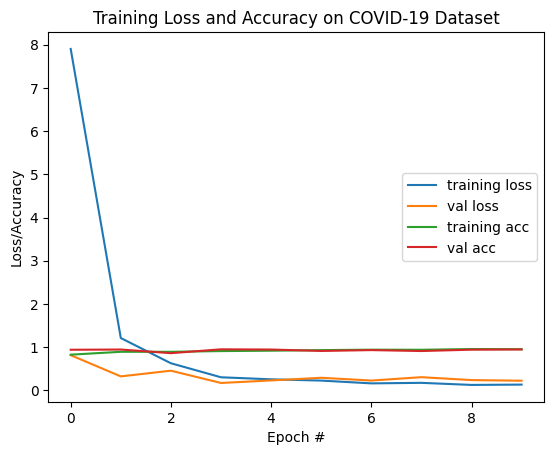

In [46]:
plt.plot(np.arange(0, EPOCHS), head.history['loss'], label='training loss')
plt.plot(np.arange(0, EPOCHS), head.history['val_loss'], label='val loss')
plt.plot(np.arange(0, EPOCHS), head.history['acc'], label='training acc')
plt.plot(np.arange(0, EPOCHS), head.history['val_acc'], label='val acc')
plt.title("Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()

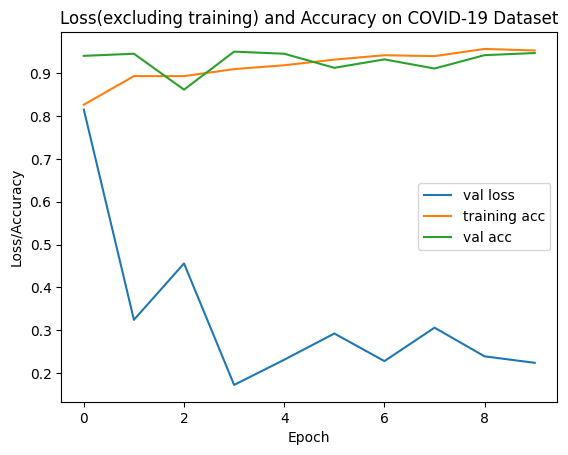

In [47]:
plt.plot(np.arange(0, EPOCHS), head.history['val_loss'], label='val loss')
plt.plot(np.arange(0, EPOCHS), head.history['acc'], label='training acc')
plt.plot(np.arange(0, EPOCHS), head.history['val_acc'], label='val acc')
plt.title('Loss(excluding training) and Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='center right')
plt.show()